In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy.signal
import plotly.graph_objs as go

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('punkt')
# nltk.download('vader_lexicon')

In [2]:
# Just setting some global params
plt.rcParams['font.size'] = 13
plt.rcParams['figure.figsize'] = [8.0, 6.0]

# Setting face color as white to make the labels and titles visible on graphs in dark mode enabled devices
plt.rcParams['figure.facecolor'] = 'white'

## FFVII Original (1997)

In [3]:
# Importing the dataset
df = pd.read_csv('.\\datasets\\ff7-script.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6242 entries, 0 to 6241
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Original   6242 non-null   object
 1   Character  6242 non-null   object
 2   Dialogue   6242 non-null   object
 3   Wordcount  6242 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 195.2+ KB


,Wordcount
count,6242.00000
mean,11.46908
std,15.89785
min,1.00000
25%,4.00000
50%,8.00000
75%,14.00000
max,438.00000


In [4]:
df.sample(4)

,Original,Character,Dialogue,Wordcount
5380,NPC: The Ropeway takes you to the 'Gold Saucer...,NPC,The Ropeway takes you to the 'Gold Saucer'. It...,15
5862,"On-screen: Received ""Master Magic"" Materia!",On-screen,"Received ""Master Magic"" Materia!",4
3073,"Dyne: Hey, Barret! It's not over yet! Everyone...",Dyne,"Hey, Barret! It's not over yet! Everyone's wai...",14
6077,"On-screen: Received ""Yoshiyuki""!",On-screen,"Received ""Yoshiyuki""!",2


Total wordcount in the game:
71590


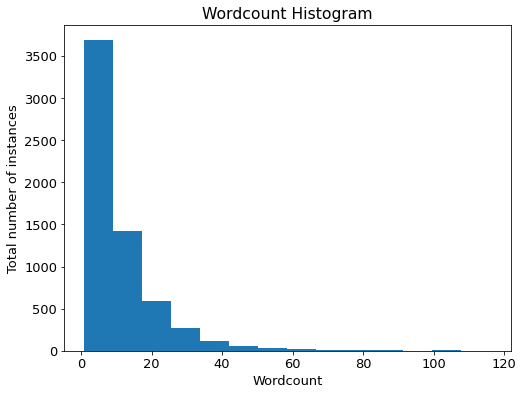

In [5]:
print('Total wordcount in the game:')
print(df['Wordcount'].sum())

plt.hist(df.query('Wordcount < 120')['Wordcount'], bins=14)
plt.title('Wordcount Histogram')
plt.ylabel('Total number of instances')
plt.xlabel('Wordcount')
plt.show()

In [6]:
# Fixing a typo
wrong_name = df.query("Character == 'RedXIII' ").index

for index in wrong_name:
    df.loc[wrong_name, 'Character'] = 'Red XIII'

In [7]:
cloud_dialogue_perc = df.query("Character == 'Cloud'").count()['Dialogue'] / df.count()['Dialogue'] * 100
print(f'Cloud\'s dialogue percentage: {cloud_dialogue_perc:.2f}%')
print('\nTop 10 Characters with the Most Dialogue')
non_npc_chars = df.query("Character != 'NPC' and Character != 'NPC 1' and Character != 'NPC 2' and Character != 'NPC 3' and Character != 'NPC 4' and Character != 'NPC 5'")['Character']
a = non_npc_chars.value_counts()[:10]
a

Cloud's dialogue percentage: 12.75%

Top 10 Characters with the Most Dialogue


Cloud         796
Tifa          465
Barret        459
Aeris         386
On-screen     318
Yuffie        196
Red XIII      165
Cid           110
Bugenhagen     88
Sephiroth      77
Name: Character, dtype: int64

In [8]:
print('Number of unique characters: ', len(df['Character'].unique()))

Number of unique characters:  134


In [9]:
# Using plotly here because it provides beautiful, interactive graphs

fig = go.Figure(data=[go.Pie(labels=a.index, values=a)])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title='Dialogue Distribution of the Characters (FF7-1997)', width=800, height=600, autosize=False);

# fig.show()

<img src="./img/dia_dist_1997.png" alt="Dialogue Distribution-1997" />

The most talking character in the game is Cloud, our protagonist, unsurprisingly. Followed by Tifa, Barret, Aerith and On-screen text.

In [10]:
# Reset global params
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### Positivity and Negativity Values of the Lines

In [11]:
# We only need the Dialogue column

df_dia = df['Dialogue']
df_dia.sample(4)

995             No, Aeris! I can't have you get involved.
5631    Hey, have you heard? Something awful happened!...
4701    Which one are you going to put in the 'Chocobo...
3655    What are you going to do, Cid? If we cancel no...
Name: Dialogue, dtype: object

In [12]:
# Measuring the sentimental intensity of each sentence in the dialogue column
# and appending their corresponding scores to their own list
# For example, positivity[200] and negativity[200] contains the positivity and negativity score
# of the 200th line in the game, respectively.

positivity = []
negativity = []

for sentence in df_dia:
    sia = SentimentIntensityAnalyzer()
    ss = sia.polarity_scores(sentence)
    negativity.append(ss['neg'])
    positivity.append(ss['pos'])    

In [13]:
packet_size = 100

# Splitting array into chunks and get the mean of these chunks
# in order to better visualize the scores (otherwise it gets really spiky)

def split_mean(arr, packet_size):
    arr = np.array(arr)
    split_arr = np.array_split(arr, len(df_dia) // packet_size)
    mean_arr = []
    
    for el in split_arr:
        mean_arr.append(el.mean())
    
    return mean_arr

mean_pos = split_mean(positivity, packet_size)
mean_neg = split_mean(negativity, packet_size)

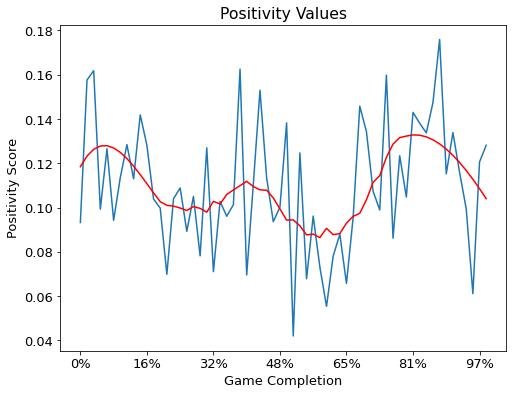

In [14]:
# Plotting the positivity values and smoothing the data with
# Savitzky–Golay filter to see the trend more easily 

ax = pd.DataFrame(mean_pos).plot()

plt.title('Positivity Values')
plt.ylabel('Positivity Score')
plt.xlabel('Game Completion')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(mean_pos)))
ax.get_legend().remove()

smooth_or_pos = scipy.signal.savgol_filter(mean_pos, 25, 3)
plt.plot(smooth_or_pos, color='red')

plt.show()

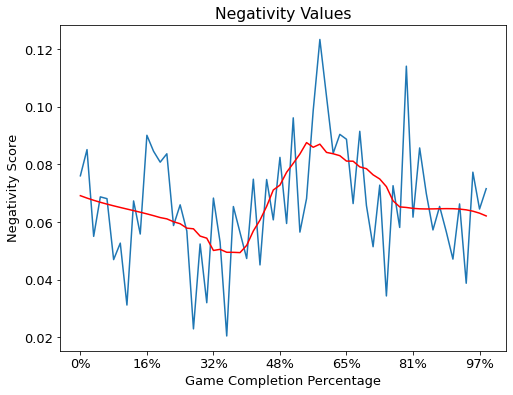

In [15]:
ax = pd.DataFrame(mean_neg).plot()

plt.title('Negativity Values')
plt.ylabel('Negativity Score')
plt.xlabel('Game Completion Percentage')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(mean_pos)))
ax.get_legend().remove()

smooth_or_neg = scipy.signal.savgol_filter(mean_neg, 25, 3)
plt.plot(smooth_or_neg, color='red')

plt.show()

## FF7 Remake (2020)

In [16]:
# Importing the dataset
df_rm = pd.read_csv('.\\datasets\\ff7-remake-script.csv')
df_rm.info()
df_rm.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8551 entries, 0 to 8550
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Original   8551 non-null   object
 1   Character  8551 non-null   object
 2   Dialogue   8551 non-null   object
 3   Wordcount  8551 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 267.3+ KB


,Wordcount
count,8551.000000
mean,9.432815
std,10.643885
min,1.000000
25%,3.000000
50%,6.000000
75%,12.000000
max,143.000000


In [17]:
df_rm.sample(4)

,Original,Character,Dialogue,Wordcount
2502,Security Officer: Heads up! We got company!,Security Officer,Heads up! We got company!,5
4192,Scotch: Let it wash over yourestore you inside...,Scotch,Let it wash over you—restore you inside and out!,9
2111,Heidegger: Don't worry. I treat my people more...,Heidegger,Don't worry. I treat my people more than fairl...,13
2497,Tifa: Barret!? Who are you talking to?,Tifa,Barret!? Who are you talking to?,6


Total wordcount in the game:
80660


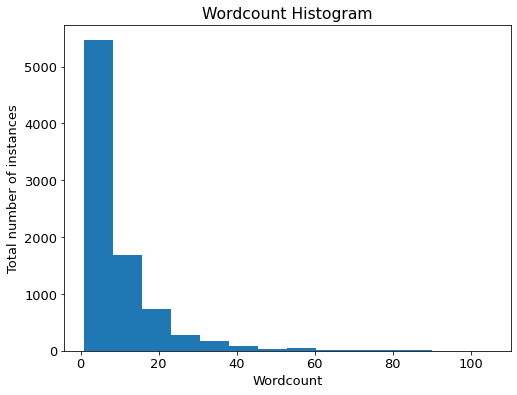

In [18]:
print('Total wordcount in the game:')
print(df_rm['Wordcount'].sum())

plt.hist(df_rm.query('Wordcount < 120')['Wordcount'], bins=14)
plt.title('Wordcount Histogram')
plt.ylabel('Total number of instances')
plt.xlabel('Wordcount')
plt.show()

In [19]:
print('\nTop 10 Characters with the Most Dialogue')

b = df_rm['Character'].value_counts()[:10]
b


Top 10 Characters with the Most Dialogue


Cloud        1474
Barret       1070
Tifa          943
Aerith        798
Yuffie        370
Jessie        263
On-screen     223
Biggs         185
Wedge         157
Sonon         134
Name: Character, dtype: int64

In [20]:
print('Number of unique characters: ', len(df_rm['Character'].unique()))

Number of unique characters:  240


In [21]:
fig = go.Figure(data=[go.Pie(labels=b.index, values=b)])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title='Dialogue Distribution of the Characters (FF7 Remake-2020)', width=800, height=600, autosize=False);
# fig.show()

<img src="./img/dia_dist_2020.png" alt="Dialogue Distribution-2020" />

In [22]:
df_rm_dia = df_rm['Dialogue']

### Positivity and Negativity Values of the Lines

In [23]:
positivity_rm = []
negativity_rm = []

for sentence in df_rm_dia:
    sia = SentimentIntensityAnalyzer()
    ss = sia.polarity_scores(sentence)
    negativity_rm.append(ss['neg'])
    positivity_rm.append(ss['pos'])

In [24]:
packet_size = 100

mean_pos = split_mean(positivity_rm, packet_size)
mean_neg = split_mean(negativity_rm, packet_size)

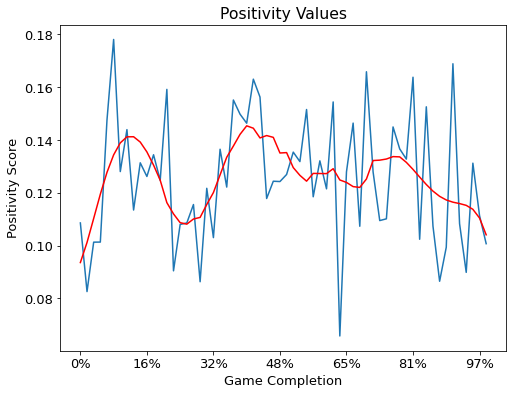

In [25]:
ax = pd.DataFrame(mean_pos).plot()

plt.title('Positivity Values')
plt.ylabel('Positivity Score')
plt.xlabel('Game Completion')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(mean_pos)))
ax.get_legend().remove()

smooth_rm_pos = scipy.signal.savgol_filter(mean_pos, 25, 5)
plt.plot(smooth_rm_pos, color='red')

plt.show()

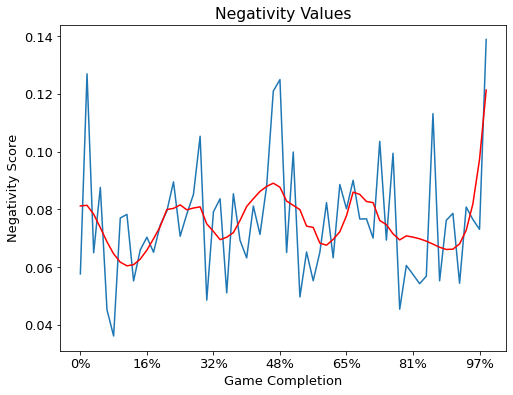

In [26]:
ax = pd.DataFrame(mean_neg).plot()

plt.title('Negativity Values')
plt.ylabel('Negativity Score')
plt.xlabel('Game Completion')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(mean_neg)))
ax.get_legend().remove()

smooth_rm_neg = scipy.signal.savgol_filter(mean_neg, 25, 5)
plt.plot(smooth_rm_neg, color='red')

plt.show()

### Positivity Comparison

FF7 remake does not cover all of the original FF7's story. So, I had to cut down original's lines. FF7 Remake ends when our party leaves Midgar, so I picked up only the first Midgar portion of the original game's script.

In [27]:
# This is the last line before leaving Midgar :( 
df_dia.iloc[1769]

"We'll see you at Kalm!"

In [28]:
# Cutting original game's scores

pos_cut = positivity[:1769]
neg_cut = negativity[:1769]

In [29]:
mean_pos_cut = split_mean(pos_cut, packet_size)
mean_neg_cut = split_mean(neg_cut, packet_size)

smooth_pos_cut = scipy.signal.savgol_filter(mean_pos_cut, 25, 5)
smooth_neg_cut = scipy.signal.savgol_filter(mean_neg_cut, 25, 5)

In [30]:
# Setting a special param for the next graph
plt.rcParams['figure.figsize'] = [10,5]

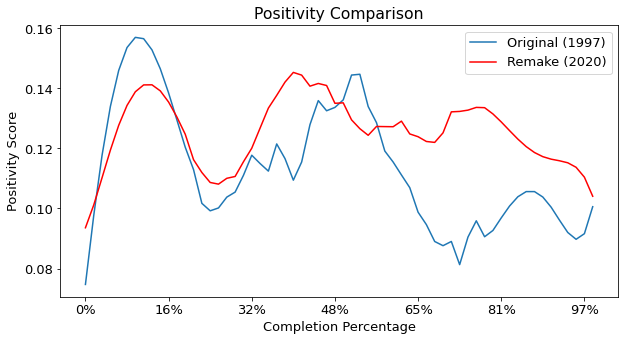

In [31]:
ax = pd.DataFrame(smooth_pos_cut).plot()

plt.plot(smooth_rm_pos, color= 'red')

plt.title('Positivity Comparison')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(smooth_pos_cut)))
plt.ylabel('Positivity Score')
plt.xlabel('Completion Percentage')
plt.legend(['Original (1997)', 'Remake (2020)'])

plt.show()